#Named Entity Recognition

# 1 bi-lstm + 1 self-attention + feature (word2vec) + hidden_dim = 100


gigi 200



In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [0]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


id = '1m2je3m7MiyHJynZv8bUtmUYWUJy7vCTl'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')

id = '1Cm_SL9JHgJ6_1qh6FeuOpUFi_-lbtQw3'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('val.csv')

id = '18Av4rRPwnlCdF2V4wXKioYlPNy7DgzFJ'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')

import pandas as pd
df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")

In [0]:
# create a list of Sentence and a list of NER

sentences_train = df_train['Sentence'].tolist()
ner_train = df_train['NER'].tolist()

# split each sentence by " "
sentence_train_split = []
ner_train_split = []
for each_sentence in sentences_train:
    each_sentence = each_sentence.split(" ")
    sentence_train_split.append(each_sentence)

for each_ner in ner_train:
    each_ner = each_ner.split(" ")
    ner_train_split.append(each_ner)
print(sentence_train_split[1][0])

eu


In [0]:
sentences_val = df_val['Sentence'].tolist()
ner_val = df_val['NER'].tolist()

# split each sentence by " "
sentence_val_split = []
ner_val_split = []
for each_sentence in sentences_val:
    each_sentence = each_sentence.split(" ")
    sentence_val_split.append(each_sentence)

for each_ner in ner_val:
    each_ner = each_ner.split(" ")
    ner_val_split.append(each_ner)


In [0]:
# create a list of Sentence and a list of NER

sentences_test = df_test['Sentence'].tolist()
# ner_test = df_test['NER'].tolist()

# split each sentence by " "
sentence_test_split = []
# ner_test_split = []
for each_sentence in sentences_test:
    each_sentence = each_sentence.split(" ")
    sentence_test_split.append(each_sentence)



There are 5 kinds of tag in total.

'I-ORG': Organization

'O': Other

'I-LOC': Location 

'I-PER': Person 

'I-MISC': Misc

In [0]:
ner_train_list = []
for each_ner in ner_train_split:
    for each_tag in each_ner:
        ner_train_list.append(each_tag)
ner_train_set = list(set(ner_train_list))
print(len(ner_train_list))
print(len(ner_train_set))
print(ner_train_set)

39572
5
['I-PER', 'I-MISC', 'I-LOC', 'I-ORG', 'O']


In [0]:
ner_val_list = []
for each_ner in ner_val_split:
    for each_tag in each_ner:
        ner_val_list.append(each_tag)
ner_val_set = list(set(ner_val_list))
print(len(ner_val_list))
print(len(ner_val_set))
print(ner_val_set)

7556
5
['I-PER', 'I-MISC', 'I-LOC', 'I-ORG', 'O']


In [0]:
# count the number of each tag
num_org = 0
num_o = 0
num_loc = 0
num_per = 0
num_misc = 0
for i in ner_train_list:
    if i=='I-ORG':
        num_org += 1
    if i=='O':
        num_o += 1
    if i=='I-LOC':
        num_loc += 1
    if i=='I-PER':
        num_per += 1
    if i=='I-MISC':
        num_misc += 1
print("I-ORG:  ", num_org)
print("O:      ", num_o)
print("I-LOC:  ", num_loc)
print("I-PER:  ", num_per)
print("I-MISC: ", num_misc)

I-ORG:   1526
O:       32137
I-LOC:   1994
I-PER:   2840
I-MISC:  1075


In [0]:
# count the number of each tag
num_org = 0
num_o = 0
num_loc = 0
num_per = 0
num_misc = 0
for i in ner_val_list:
    if i=='I-ORG':
        num_org += 1
    if i=='O':
        num_o += 1
    if i=='I-LOC':
        num_loc += 1
    if i=='I-PER':
        num_per += 1
    if i=='I-MISC':
        num_misc += 1
print("I-ORG:  ", num_org)
print("O:      ", num_o)
print("I-LOC:  ", num_loc)
print("I-PER:  ", num_per)
print("I-MISC: ", num_misc)

I-ORG:   285
O:       5790
I-LOC:   419
I-PER:   875
I-MISC:  187


In the data, you can see the different types of entities: 
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

## Data Preprocessing
There are too many NaN values in ‘Sentence #” column, fill NaN by preceding values.
We have 47595 sentences that contain 35172 unique words and tagged by 17 tags.

We will now train a CRF model for named entity recognition using sklearn-crfsuite on our dataset. As mentioned before, MEMM or CRF is often used for labeling or parsing of sequential data for named entity recognition.

In [0]:
!pip install sklearn_crfsuite

##Conditional random fields (CRF)

In [0]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter

In [0]:
print(len(sentence_train_split), len(ner_train_split))
print(len(sentence_val_split), len(ner_val_split))

3000 3000
700 700


In [0]:
#Retrieving sentences with their tags in zip
zip_sentences_train = []
for line in range(len(sentence_train_split)):
    combine_sentence = []
    for each_word, each_tag in zip(sentence_train_split[line], ner_train_split[line]):
        combine_sentence.append((each_word, each_tag))
    zip_sentences_train.append(combine_sentence)


for i in range(5):
    print(zip_sentences_train[i])

[('-docstart-', 'O')]
[('eu', 'I-ORG'), ('rejects', 'O'), ('german', 'I-MISC'), ('call', 'O'), ('to', 'O'), ('boycott', 'O'), ('british', 'I-MISC'), ('lamb', 'O'), ('.', 'O')]
[('peter', 'I-PER'), ('blackburn', 'I-PER')]
[('brussels', 'I-LOC'), ('1996-08-22', 'O')]
[('the', 'O'), ('european', 'I-ORG'), ('commission', 'I-ORG'), ('said', 'O'), ('on', 'O'), ('thursday', 'O'), ('it', 'O'), ('disagreed', 'O'), ('with', 'O'), ('german', 'I-MISC'), ('advice', 'O'), ('to', 'O'), ('consumers', 'O'), ('to', 'O'), ('shun', 'O'), ('british', 'I-MISC'), ('lamb', 'O'), ('until', 'O'), ('scientists', 'O'), ('determine', 'O'), ('whether', 'O'), ('mad', 'O'), ('cow', 'O'), ('disease', 'O'), ('can', 'O'), ('be', 'O'), ('transmitted', 'O'), ('to', 'O'), ('sheep', 'O'), ('.', 'O')]


In [0]:
#Retrieving sentences with their tags in zip
zip_sentences_val = []
for line in range(len(sentence_val_split)):
    combine_sentence_val = []
    for each_word, each_tag in zip(sentence_val_split[line], ner_val_split[line]):
        combine_sentence_val.append((each_word, each_tag))
    zip_sentences_val.append(combine_sentence_val)


for i in range(5):
    print(zip_sentences_val[i])

[('-docstart-', 'O')]
[('cricket', 'O'), ('-', 'O'), ('leicestershire', 'I-ORG'), ('take', 'O'), ('over', 'O'), ('at', 'O'), ('top', 'O'), ('after', 'O'), ('innings', 'O'), ('victory', 'O'), ('.', 'O')]
[('london', 'I-LOC'), ('1996-08-30', 'O')]
[('west', 'I-MISC'), ('indian', 'I-MISC'), ('all-rounder', 'O'), ('phil', 'I-PER'), ('simmons', 'I-PER'), ('took', 'O'), ('four', 'O'), ('for', 'O'), ('38', 'O'), ('on', 'O'), ('friday', 'O'), ('as', 'O'), ('leicestershire', 'I-ORG'), ('beat', 'O'), ('somerset', 'I-ORG'), ('by', 'O'), ('an', 'O'), ('innings', 'O'), ('and', 'O'), ('39', 'O'), ('runs', 'O'), ('in', 'O'), ('two', 'O'), ('days', 'O'), ('to', 'O'), ('take', 'O'), ('over', 'O'), ('at', 'O'), ('the', 'O'), ('head', 'O'), ('of', 'O'), ('the', 'O'), ('county', 'O'), ('championship', 'O'), ('.', 'O')]
[('their', 'O'), ('stay', 'O'), ('on', 'O'), ('top', 'O'), (',', 'O'), ('though', 'O'), (',', 'O'), ('may', 'O'), ('be', 'O'), ('short-lived', 'O'), ('as', 'O'), ('title', 'O'), ('rivals', 

We extract more features (word parts, simplified POS tags, lower/title/upper flags, features of nearby words) and convert them to sklearn-crfsuite format — each sentence should be converted to a list of dicts. The following code were taken from [sklearn-crfsuites official site](https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html).

In [0]:
def word2features(sent, i):
    word = sent[i][0]
    # postag = sent[i][1]
    # a few features: upper? lower? title? 
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:], # last three letters of the word
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(), 
        'word.istitle()': word.istitle(), # is it a title?
        'word.isdigit()': word.isdigit(), # is it a digit?
       
    }
    # features of the previous word
    if i > 0:
        word1 = sent[i-1][0]
        # postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
          
        })
    else:
        features['BOS'] = True
    # features of the next word
    if i < len(sent)-1:
        word1 = sent[i+1][0]
       
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            
        })
    else:
        features['EOS'] = True
    return features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]
def sent2labels(sent):
    return [label for token, label in sent]
def sent2tokens(sent):
    return [token for token, label in sent]

In [0]:
#data splitting for training and testing

features_train = [sent2features(s) for s in zip_sentences_train]
labels_train = [sent2labels(s) for s in zip_sentences_train]

features_val = [sent2features(s) for s in zip_sentences_val]
labels_val = [sent2labels(s) for s in zip_sentences_val]


In [0]:
# train a CRF model for named entity recognition using sklearn-crfsuite 
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(features_train, labels_train)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

Because tag “O” (outside) is the most common tag and it will make our results look much better than they actual are. So we remove tag “O” when we evaluate classification metrics.

B: begining of ... 
I: identity

In [0]:
ner_train_set.remove('O')
classes = ner_train_set
print(classes)

['I-PER', 'I-MISC', 'I-LOC', 'I-ORG']


In [0]:
#evaluation
y_pred = crf.predict(features_val)
print(metrics.flat_classification_report(labels_val, y_pred, labels=classes))

              precision    recall  f1-score   support

       I-PER       0.93      0.80      0.86       875
      I-MISC       0.83      0.63      0.72       187
       I-LOC       0.89      0.85      0.87       419
       I-ORG       0.85      0.58      0.69       285

   micro avg       0.90      0.76      0.82      1766
   macro avg       0.88      0.72      0.78      1766
weighted avg       0.90      0.76      0.82      1766



The following shows what our classifier learned. It is very likely that the beginning of a geographical entity (B-geo) will be followed by a token inside geographical entity (I-geo), but transitions to inside of an organization name (I-org) from tokens with other labels are penalized hugely.

In [0]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(5))
print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-5:])

Top likely transitions:
I-PER  -> I-PER   3.403927
I-ORG  -> I-ORG   3.384090
I-MISC -> I-MISC  2.828140
I-LOC  -> I-LOC   2.064296
O      -> O       0.776679

Top unlikely transitions:
I-PER  -> I-LOC   -2.677780
I-PER  -> I-ORG   -2.689004
I-LOC  -> I-PER   -3.410616
I-ORG  -> I-LOC   -3.463856
I-ORG  -> I-PER   -3.736825


## Bi-LSTM CRF model

Now we will apply the Bi-LSTM CRF model we just learned to CoNLL 2003 NER dataset using the pretrained glove embeddings. Please go through and complete the [Function for accuracy] section. 



#### Generate word_to_ix and tag_to_ix

In [0]:
word_to_ix = {}
for sentence in sentence_train_split + sentence_val_split + sentence_test_split:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_list = list(word_to_ix.keys())

START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix = {START_TAG:0, STOP_TAG:1}
for tags in ner_train_split + ner_val_split:
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)


In [0]:
print(tag_to_ix)

{'<START>': 0, '<STOP>': 1, 'O': 2, 'I-ORG': 3, 'I-MISC': 4, 'I-PER': 5, 'I-LOC': 6}


#### Generate Embedding Matrix

In [0]:
import gensim.downloader as api
word_emb_model = api.load("glove-wiki-gigaword-200") 

EMBEDDING_DIM = 200

embedding_matrix = []
num_except = 0
for word in word_list:
    try:
        embedding_matrix.append(word_emb_model.wv[word])
    except:
        num_except += 1
        embedding_matrix.append([0]*EMBEDDING_DIM) 

embedding_matrix = np.array(embedding_matrix)
embedding_matrix.shape



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


(13972, 200)

#### convert dataset into idxs

In [0]:
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] for w in sent])
    return input_index_list

# use the index to represent each word in each sentence
train_input_index =  to_index(sentence_train_split, word_to_ix)
train_output_index = to_index(ner_train_split, tag_to_ix)
val_input_index = to_index(sentence_val_split, word_to_ix)
val_output_index = to_index(ner_val_split, tag_to_ix)
test_input_index = to_index(sentence_test_split, word_to_ix)


### Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))


class BiLSTM_CRF(nn.Module):


    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        # Use nn.Embedding
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        # Use the embedding matrix as the initial weights of nn.Embedding
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))

        self.lstm_1 = nn.LSTM(2*embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)
        # self.lstm_2 = nn.LSTM(2*hidden_dim, hidden_dim // 2, num_layers=1, bidirectional=True)
        # self.lstm_3 = nn.LSTM(self.embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()


    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))
    
    # CRF: use the transition matrix to train our model
    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.
        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def cal_self_attention(self, hidden, method):
        # 1st type of calculation of the attention: Dot Product
        if method == 'Dot Product':
            a = torch.bmm(hidden, hidden.permute(0,2,1)) # [1, seq, 50] * [1,50,seq] = [1,seq, seq]
            attn_weights = F.softmax(a, dim = -1)
            attn_output = torch.bmm(attn_weights, hidden) 
            concat_output = torch.cat((attn_output, hidden), -1)
           
        # 2nd type of calculation of the attention: Scaled Dot Product
        elif method == 'Scale Dot Product':
            a = torch.bmm(hidden, hidden.permute(0,2,1))
            attn_weights = F.softmax((1/np.sqrt(self.hidden_dim))*a, dim = -1)
            attn_output = torch.bmm(attn_weights, hidden) 
            concat_output = torch.cat((attn_output, hidden), -1)

        return concat_output

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        attn_output1 = self.cal_self_attention(embeds, 'Scale Dot Product')

        # lstm_out_summary, (h_n,c_n) = self.lstm_3(embeds, self.hidden) 
        # attn_output1 = self.cal_self_attention(lstm_out_summary, 'Scale Dot Product')
        lstm_out_1, self.hidden = self.lstm_1(attn_output1, self.hidden) 
      
        lstm_out = lstm_out_1.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    ''' Calculate the score for the viterbi decoding'''
    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

#### Function for accuracy


Please complete the cal_acc function that generates the model predictions using the input data and calculates the accuracy by comparing the model predictions with the ground truth labels. You can refer to the [Train the model] section regarding what the inputs and outputs are and how it will be used.

In [0]:
from sklearn.metrics import accuracy_score
import numpy as np
def cal_acc(model, input_index, output_index):
    ground_truth = []
    predicted = []
    for i in range(len(input_index)):
      input_index_tensor = torch.tensor(input_index[i]).to(device)
      # add elements of tuple to list
      ground_truth.extend(output_index[i])
      _, outputs = model(input_index_tensor)
      predicted.extend(outputs)
      accuracy = accuracy_score(predicted, ground_truth)
      
    return ground_truth, predicted, accuracy

#### Initialize Model

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 100

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

#### Train the model

In [0]:
"""Each epoch will take about 300s"""

import datetime
epoch_list = []
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(20):  
    epoch_list.append(epoch) 
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
    train_loss_list.append(train_loss)
    model.eval()
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    train_acc_list.append(train_acc)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


Epoch:1, Training loss: 31952.15, train acc: 0.8556, val loss: 3448.05, val acc: 0.8425, time: 334.79s
Epoch:2, Training loss: 12859.37, train acc: 0.9260, val loss: 2252.78, val acc: 0.9112, time: 336.27s
Epoch:3, Training loss: 8518.09, train acc: 0.9477, val loss: 2016.86, val acc: 0.9197, time: 336.45s
Epoch:4, Training loss: 6238.74, train acc: 0.9610, val loss: 1897.49, val acc: 0.9246, time: 332.99s
Epoch:5, Training loss: 4722.39, train acc: 0.9703, val loss: 1836.70, val acc: 0.9273, time: 329.90s
Epoch:6, Training loss: 3628.57, train acc: 0.9769, val loss: 1750.36, val acc: 0.9291, time: 330.05s
Epoch:7, Training loss: 2756.41, train acc: 0.9835, val loss: 1711.85, val acc: 0.9308, time: 331.17s
Epoch:8, Training loss: 2122.33, train acc: 0.9880, val loss: 1707.26, val acc: 0.9325, time: 330.19s
Epoch:9, Training loss: 1612.79, train acc: 0.9917, val loss: 1756.98, val acc: 0.9338, time: 331.58s
Epoch:10, Training loss: 1208.54, train acc: 0.9944, val loss: 1809.47, val acc:

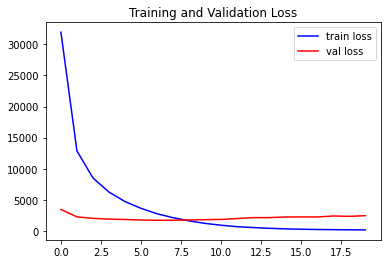

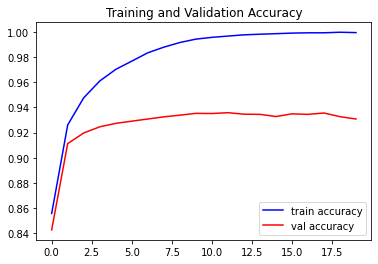

In [0]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(epoch_list,  train_loss_list, 'b', label = 'train loss')
plt.plot(epoch_list, val_loss_list, 'r', label = 'val loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

plt.plot(epoch_list, train_acc_list, 'b', label = 'train accuracy')
plt.plot(epoch_list, val_acc_list, 'r', label = 'val accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



### Testing

In [0]:
y_true, y_pred,_ = cal_acc(model, val_input_index, val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))

              precision    recall  f1-score   support

       I-LOC     0.9282    0.8640    0.8949       419
      I-MISC     0.8165    0.6898    0.7478       187
       I-ORG     0.7734    0.5509    0.6434       285
       I-PER     0.9108    0.7931    0.8479       875
           O     0.9439    0.9851    0.9641      5790

    accuracy                         0.9325      7556
   macro avg     0.8745    0.7766    0.8196      7556
weighted avg     0.9296    0.9325    0.9293      7556



In [0]:
torch.save(model, 'Bilstm_crf_feature1_3.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
for i in range(5):
    print(y_pred_decode[i])

O
O
O
I-ORG
O


In [0]:
import numpy as np
def leaderboard(model, input_index):
    predicted = []
    for i in range(len(input_index)):
      input_index_tensor = torch.tensor(input_index[i]).to(device)
      # add elements of tuple to list
      
      _, outputs = model(input_index_tensor)
      predicted.extend(outputs)
      
    return predicted

    

In [0]:
test_pred = leaderboard(model, test_input_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]


test_pred_decode = decode_output(test_pred)

In [0]:
for i in range(5):
    print(test_pred_decode[i])
print(len(test_pred_decode))

O
O
O
I-LOC
O
46666


In [0]:
import pandas as pd

co1 = []
co2 = []
for i in range(len(test_pred_decode)):
    co1.append(i)
    co2.append(test_pred_decode[i])
leaderboard = pd.DataFrame({'Id':co1, 'Predicted':co2})
leaderboard.to_csv("leaderboard_feature1_3.csv", index=False, sep=",")

In [0]:
da=pd.read_csv("leaderboard_feature1_3.csv")
da.head(10)

,Id,Predicted
0,0,O
1,1,O
2,2,O
3,3,I-LOC
4,4,O
5,5,I-ORG
6,6,O
7,7,O
8,8,I-LOC
9,9,O


In [0]:
model.eval()

BiLSTM_CRF(
  (word_embeds): Embedding(13972, 200)
  (lstm_1): LSTM(400, 50, bidirectional=True)
  (hidden2tag): Linear(in_features=100, out_features=7, bias=True)
)